In [4]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM, ConvLSTM1D, Input, MaxPool1D
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Model, Sequential
from librosa import display
from tensorflow import keras
from tensorflow.keras import layers

from classic_generator import classic_generator
from spectrogram_class import spectrogram


ModuleNotFoundError: No module named 'classic_generator'

In [5]:
!pwd

/Users/ylee/Downloads


In [ ]:
import pickle

def save_history(history, path):
    with open(path, 'wb+') as f:
        pickle.dump(history, f)
        
def load_history(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Music transcription - MusicNet LSTM

This is a successive notebook from RNN models for OrchideaSOL dataset. In that notebook, we have demonstrate that the RNN model, in particularly LSTM, is able to capture the features of instrument and pitch in a raw audio file. 

The purpose of this notebook is to apply the same principle on the more complicated MusicNet dataset. On our previous notebook, we have had mild success of predicting more than 50% in both insturment and notes, for short single instrumental audio files.

Although it is the same principle, this time we are going to need to convert the whole sequence of audio file into the transcription in to the same music file length. To be more clear:

> For all timesteps in the spectrogram, we are going to produce the classification of instruments and note. 

The end goal of this project is to convert the corresponding output into a MIDI file.

The model architecture will be to be fine tuned since we are facing the challenges below:

* We are making classifying prediction for every timestep,  
* Excluding the expected dimension of time and notes as output, we also need the same classification for every instruments, which is 11 of them.
* The audio files are not neccessarily made of single instrument, which means that our RNN model will need to find the relation of the sound signature for each instruments, in the sea of spectrogram's magnitude.
* The audio files has different length, range from 3 minutes to 20 minutes. Padding will be required, however, zeros padding will cause problem of exploding/vanishing gradient in RNN model.

In [ ]:
# Testing if GPU is enabled, if it's not, I am not running this notebook!
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-16 16:43:02.967559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-16 16:43:02.968025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3715140090454835554
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 11023430109333998903
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2022-09-16 16:43:03.107869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-16 16:43:03.107888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Throughout this notebook, we will be using integer code number for instrument and notes classification. The instrument and note lists below are generated by concatenating the training labels, which are seperated csv files.

In [ ]:
instrument_list = [1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]


In [ ]:
note_list = [21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
             63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]


# RNN-LSTM

To begin our construction of RNN model, we introduce the architect idea for our model.

Since our model has to output the MIDI file equivalence for each instruments, we will be forking our output into 11 Dense layers, with each layer reprenting one instruments.

Each output will have a dimension of :
$$
\text{\# of instruments} \times (\text{\# of timesteps} \times \text{\# of notes})
$$

The architect idea for the model is as follow:
1. Passing input spectrogrom into convolutional layers, in order to extract features
1. Passing features in to multiple layers of Dense layers, to embed the features
1. Passing embedded features into LSTM model, to predict labels for each timestep depending on the sequnce of embedded features.


### UPDATE:

After countless time wasted on differnet architect and changing parameter, we have decided to change the input shape, instead of feeding the batch of spectrogram which are padded with the longest time dimension across the batch, we will be taken random snipshot of fixed time length across all batch. This workaround is to prevent:  
* Long padding of zeros for shorter audio files, to prevent vanishing gradient
* Long training time and 
* Reduce GPU memory usage (VsCode tends to close unexpectedly and doesn't release allocated GPU space before closing, making a full system restart required.)

We have decided to take 200 timeslices for the model input, with our default hop length (number of timestep to skip when computing fast-fourier transform for spectrogram), and using the sample rate of audio, which is 44100HZ, we can calculate that:

$$
\text{Length in second of inputs} = \frac{300 \times 200}{44100} \\
\approx 16 \, \text{seconds}
$$

In [ ]:
def instrument_layer_simple(input, out_name):
    '''
    Support function from building multiple output models. Returns an output layer
    of TimeDistributed Dense layer, corresponds to the number of notes in labels
    
    Input:
    input: Preceeding input layer to be fed into.
    out_name: str, name of output layer names to be assigned
    '''
    out = layers.TimeDistributed(Dense(len(note_list), activation='sigmoid'),
                                 name=out_name)(input)
    return out


In [ ]:
instrument_list


[1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]

Now we can start to build our (hopefully will be working this time) model.

In [ ]:
BATCH_SIZE = 8

# We have choose to work with 128 frequency bins,
# and the None input shape indicates the dynamic length of time dimension
inp = Input((None, 128, 1), batch_size=BATCH_SIZE)
normalizer = layers.BatchNormalization()(inp)

# Extracting features from first convolutional layers.
# Padding set to same to maintain same time dimension
conv_1 = Conv2D(10, (50, 40), padding = 'same')(normalizer)

normalizer_2 = layers.BatchNormalization()(conv_1)
# pool_1 = layers.TimeDistributed(MaxPool1D(2))(normalizer_2)
# flatten_1 = flatten = layers.TimeDistributed(layers.Flatten())(pool_1)

# conv_2 = layers.Conv2D(5, (1000, 30), padding = 'same')(pool_1)
# pool_2 = layers.TimeDistributed(layers.MaxPool1D(2))(conv_2)

# Flatten each filter layer for each timesteps
flatten = layers.TimeDistributed(Flatten())(normalizer_2)

# Feed in the flattened layers to multiple layers of Dense layer,
# Performing embedding
Dense_1 = layers.TimeDistributed(Dense(300, activation = 'relu'))(flatten)
normalizer_3 = layers.BatchNormalization()(Dense_1)
drop_1 = layers.Dropout(0.2)(normalizer_3)

Dense_2 = layers.TimeDistributed(Dense(150, activation = 'relu'))(drop_1)
normalizer_4 = layers.BatchNormalization()(Dense_2)
drop_2 = layers.Dropout(0.2)(normalizer_4)

Dense_3 = layers.TimeDistributed(Dense(50, activation = 'relu'))(drop_2)
normalizer_5 = layers.BatchNormalization()(Dense_3)
drop_3 = layers.Dropout(0.2)(normalizer_5)

Dense_3 = layers.TimeDistributed(Dense(200, activation = 'relu'))(drop_2)
normalizer_5 = layers.BatchNormalization()(Dense_3)
drop_3 = layers.Dropout(0.2)(normalizer_5)

# Lastly, put the decoded features in to LSTM layer
last_lstm = LSTM(500, return_sequences=True, dropout = 0.3)(drop_3)

# Outputing to final Dense layer with sigmoid activation,
# To predict the note labels for each timesteps
simple_lstm_model = Model(inp, [instrument_layer_simple(last_lstm,
                                f"instrument_{ins}") for ins in instrument_list])



2022-09-16 16:43:04.148904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-16 16:43:04.148928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


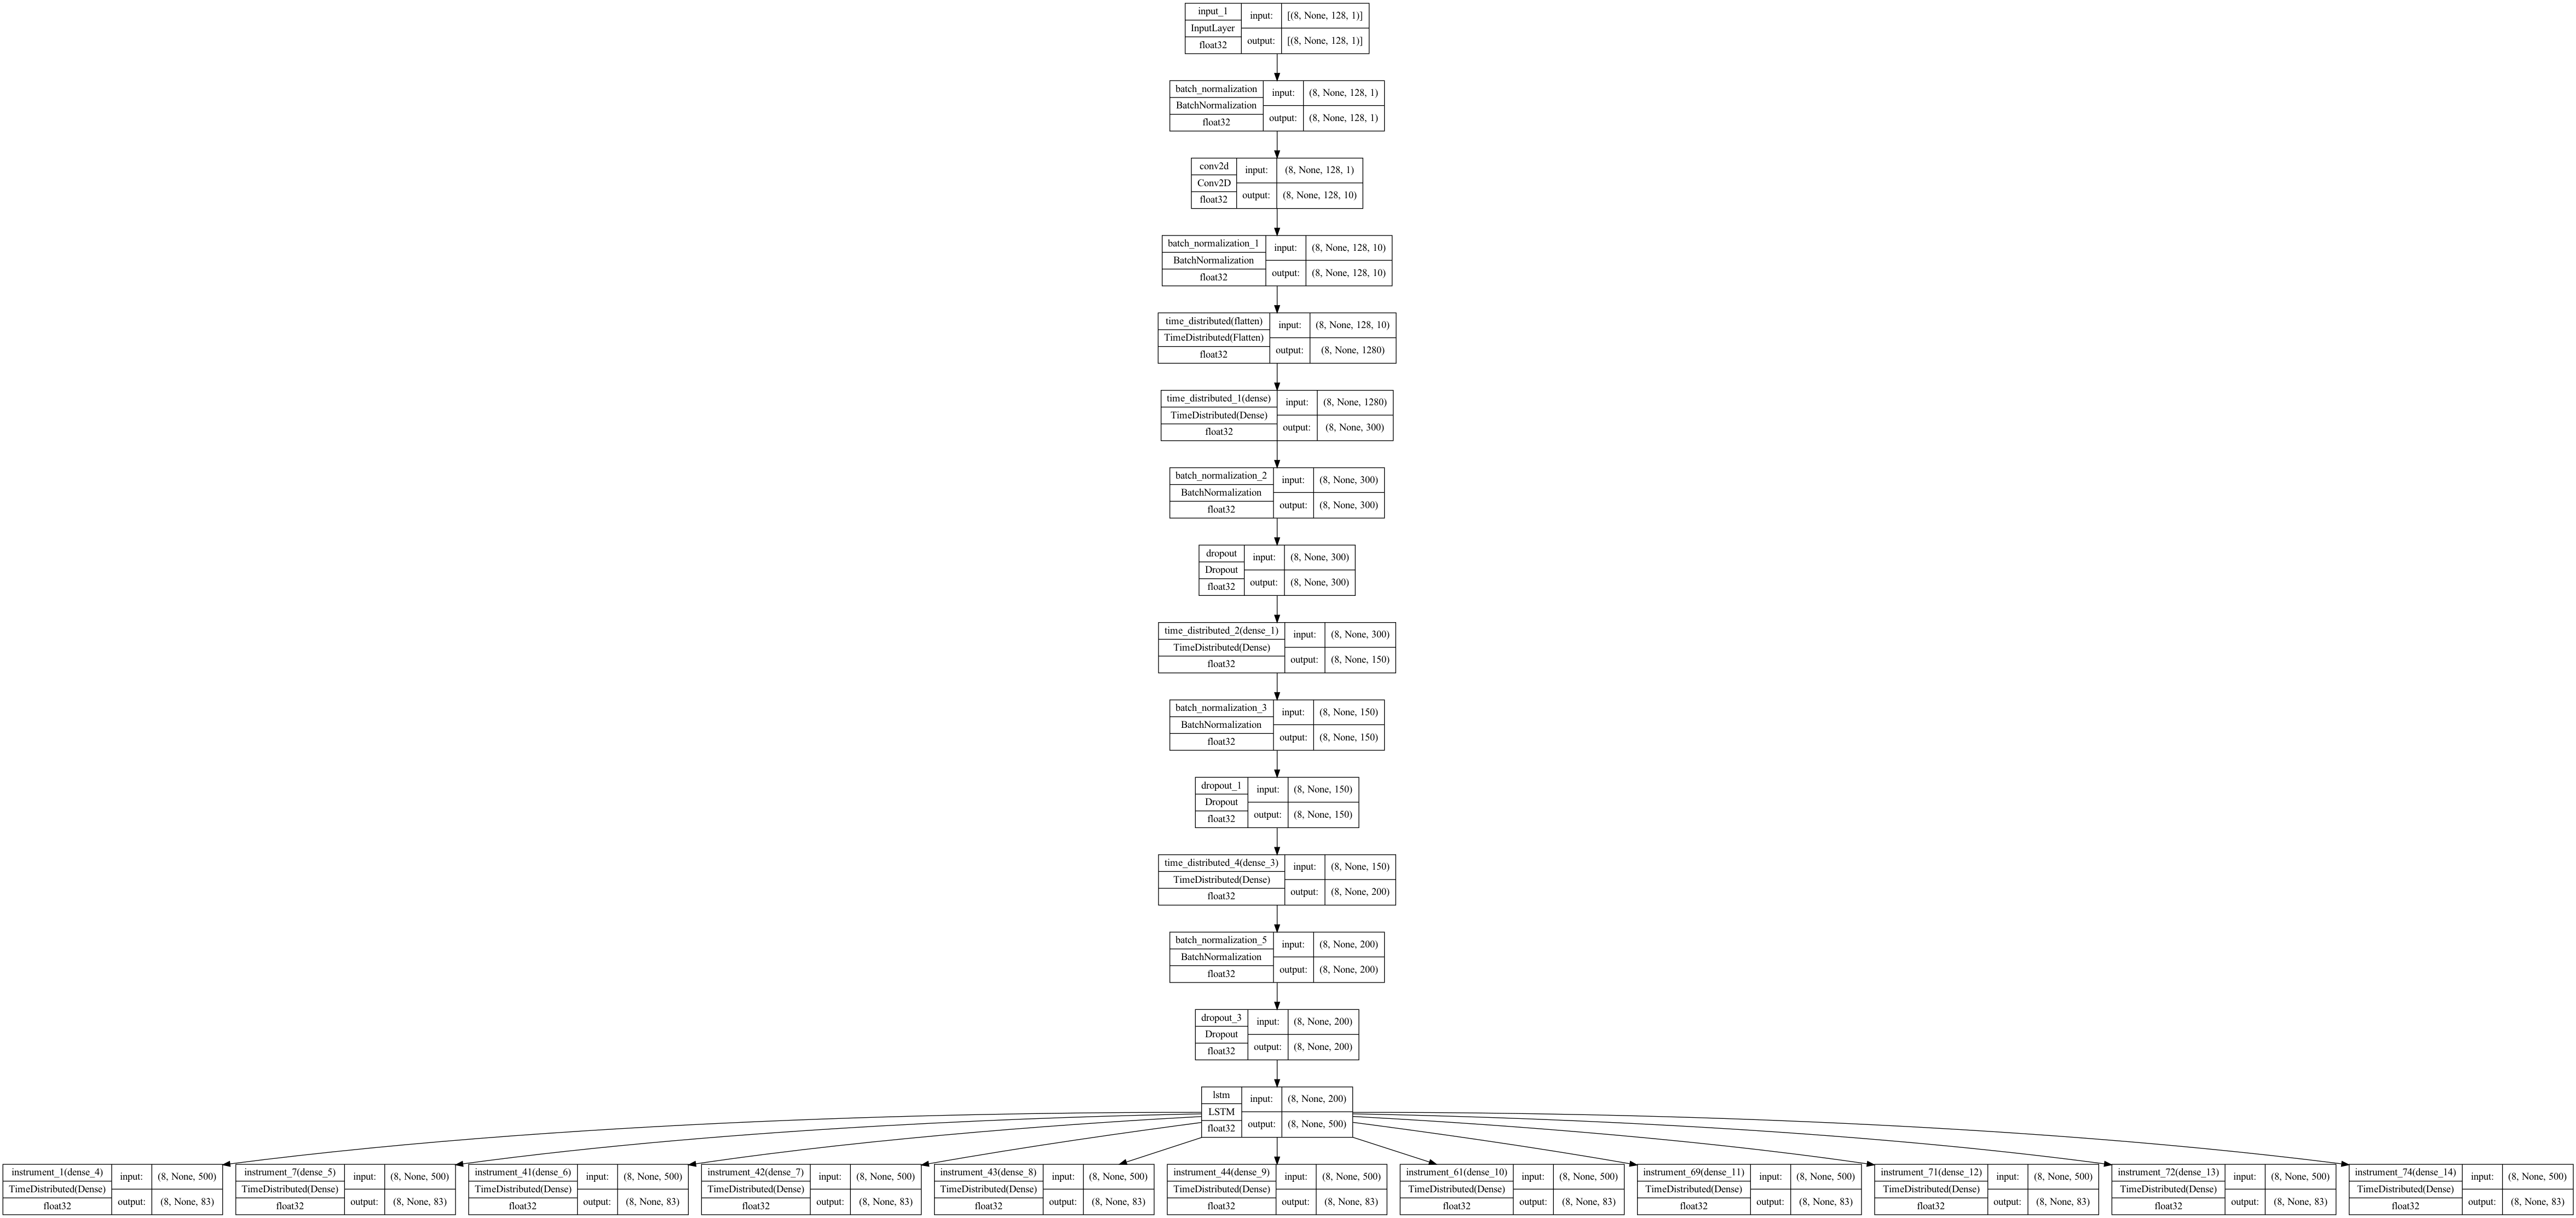

In [ ]:

tf.keras.utils.plot_model(simple_lstm_model, show_shapes=True, show_dtype=True)


In [ ]:
classic_train_generator =  classic_generator(mode='train', batch_size=BATCH_SIZE)
                        # (tf.dtypes.float32, tf.dtypes.bool))

classic_eval_generator = classic_generator(mode='test', batch_size=BATCH_SIZE)


In [ ]:
# Getting the path to the latest trained model
newest_ckpt = !ls -dt $PWD/../models/classic_truc_conv_to_lstm/* | head -1
newest_ckpt = newest_ckpt[0]
newest_ckpt


'/Users/ylee/Documents/Music_transcription_fastai/notebooks/../models/classic_truc_conv_to_lstm/20220916_135022_02_classic_truc_conv_to_lstm'

In [ ]:
# Run the following code to load the newest model

simple_lstm_model = tf.keras.models.load_model(newest_ckpt, compile=False)

Since our prediction will be a really sparse metrics, with a few 1s, we will need to define our custom loss function such that the false negatives are hugely reduced. We will be using the weighted_cross_entropy_with_logits in tensorflow, and setting positive weight which is larger than 1.

In [ ]:
def weighted_cross_entropy_with_logits(labels, logits):
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels, logits, pos_weight = 150
        )
    return loss

def my_loss():
    return weighted_cross_entropy_with_logits

# As mentioned before, since our prediction is a sparse multilabel problem, 
# the accuracy might not makes muc of sense, in addition, we will be adding
# AUC for each instrument to gauge how well the model is performing
simple_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0005),
                          loss={f"instrument_{ins}": my_loss()
                                for ins in instrument_list},
                          metrics=['accuracy', tf.keras.metrics.AUC()])


NameError: name 'simple_lstm_model' is not defined

In [ ]:
from datetime import datetime

# Define checkpoint to save model for every epoch
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/classic_truc_conv_to_lstm/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_classic_truc_conv_to_lstm",
    monitor='val_accuracy',
    save_freq='epoch')
    
# Define checkpoint to save model if validation loss is decreasing
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)


simple_lstm_history = simple_lstm_model.fit(classic_train_generator, 
                                                epochs=5,
                                                validation_data=classic_eval_generator,
                                                validation_freq=1,
                                                # use_multiprocessing= True,
                                                # workers= 3,
                                                verbose=1,
                                                callbacks=[ckpt_callback])


NameError: name 'tf' is not defined

In [17]:
# simple_lstm_model.save('../models/classic_full_convlstm/')


Since we have multiple output with 2 dimensional output, it is easier to use visualization to gauge how well the model is performing.

In [18]:
def musicnet_eval(model, generator, ins):
    '''
    Supporting function to  plot the predicted label and true labels
    of for specified instrument.
    
    Input:
    model: model to be used
    generator: testing Sequence generator to be used
    ins: int, instrument number, ranged from 0 to 10
    '''
    _feature, _label = generator.__getitem__(0)
    _prediction = model.predict(_feature)
    fig = plt.figure(figsize= (18, 6))

    ax_1 = fig.add_subplot(121)
    ax_1.set_title('Prediction')
    sns.heatmap(_prediction[ins][0], ax = ax_1)

    ax_2 = fig.add_subplot(122)
    sns.heatmap(_label[f"instrument_{instrument_list[ins]}"][0], ax = ax_2)
    ax_2.set_title('True label')

    plt.xlabel('Frequency bins')
    plt.ylabel('Timesteps')

    plt.tight_layout()
    plt.show()

In [19]:
test_generator = classic_generator(mode='test', batch_size=1)


1/1 [==============================] - 2s 2s/step


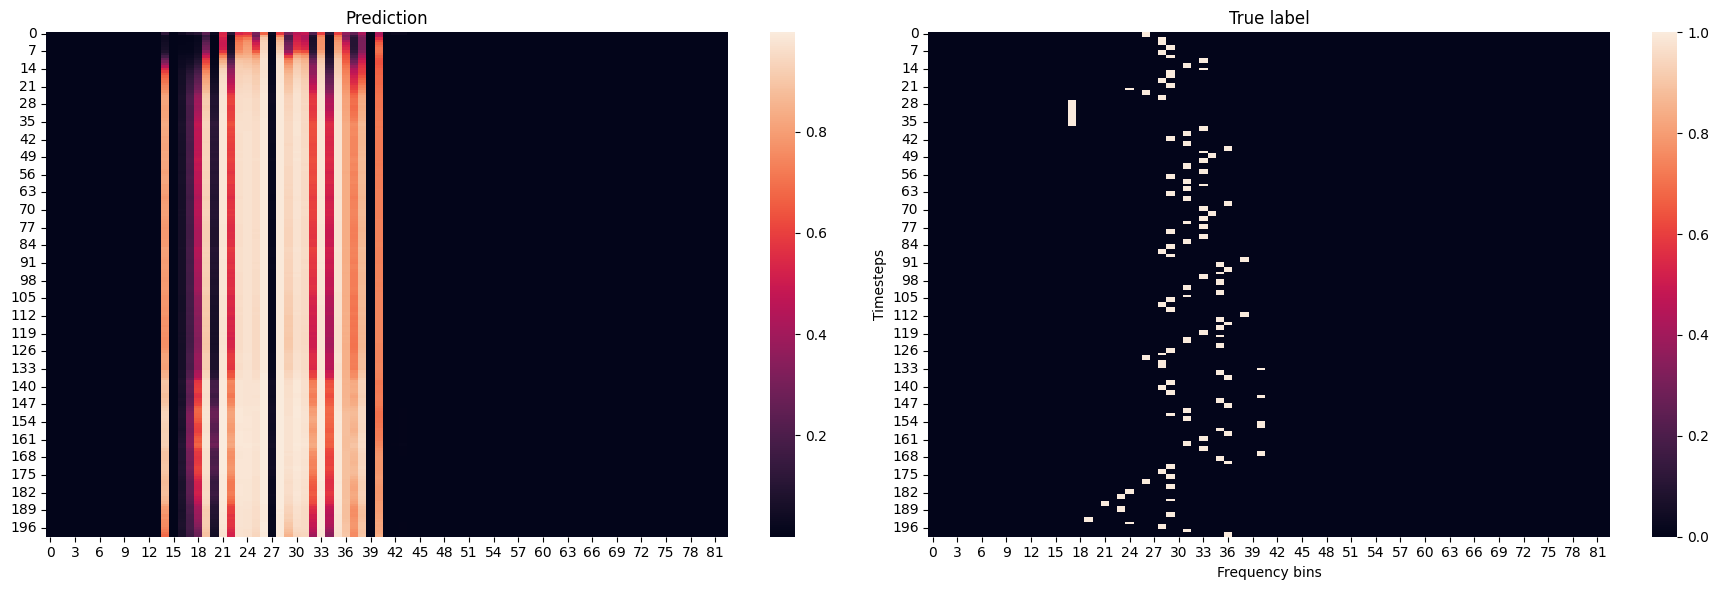

In [26]:
musicnet_eval(simple_lstm_model, test_generator, 4)

In [21]:
test_set = test_generator.__getitem__(2)


In [22]:
test_set[0].shape


(1, 200, 128, 1)

In [23]:
predict_test = simple_lstm_model.predict(test_set[0])


1/1 [==============================] - 0s 25ms/step


In [24]:
instrument_list

[1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]

<AxesSubplot:>

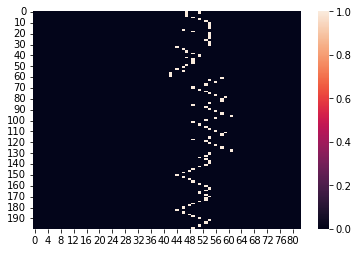

In [25]:
sns.heatmap(test_set[1]['instrument_41'][0])


In [26]:
instrument_list

[1, 7, 41, 42, 43, 44, 61, 69, 71, 72, 74]

The problem with this model is that the model is predicting contant value along timesteps. The model focused and retained the sequential relation across timesteps too much. And eventually learned to predict zeros for all scenarios. Look at figure below for a better visualization.

# 2 lstm

Our first model produced unsatisfactory results, which implies we might have to start from a simpler model, we will be starting again at a model with 2 LSTM layers. 

In [27]:
BATCH_SIZE = 16

inp = Input((None, 128), batch_size=BATCH_SIZE)

# 2 LSTM layers
x = LSTM(500, return_sequences=True, dropout = 0.3, stateful = True)(inp)
x = LSTM(500, return_sequences=True, dropout = 0.3, stateful = True)(x)

lstm_2 = Model(inp, [instrument_layer_simple(x,
                                f"instrument_{ins}") for ins in instrument_list])


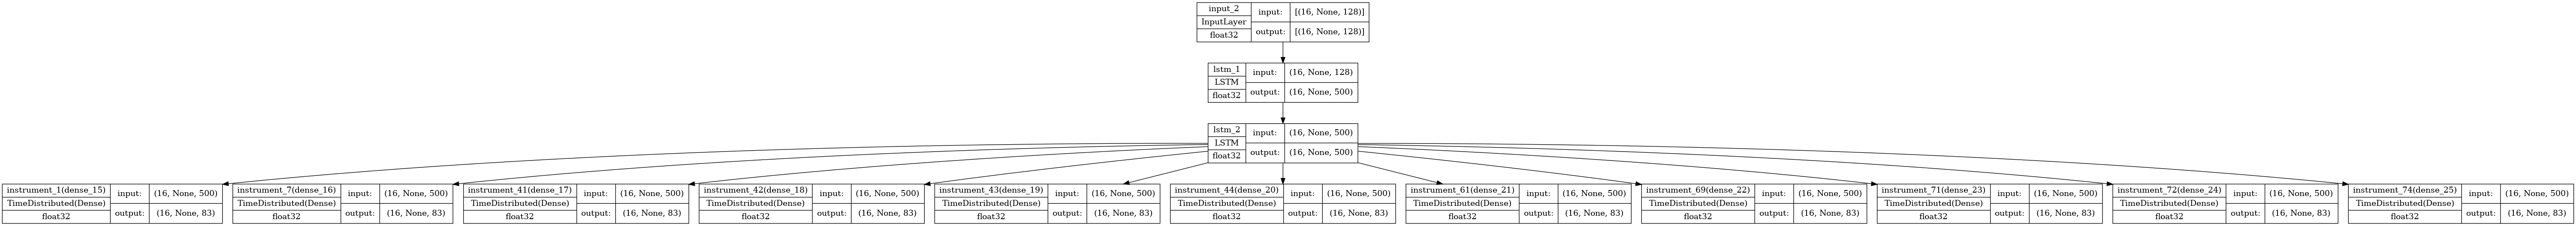

In [28]:
tf.keras.utils.plot_model(lstm_2, show_shapes=True, show_dtype=True)


In [29]:
lstm2_train_generator =  classic_generator(mode='train', batch_size=BATCH_SIZE, expand_dim = False)
                        # (tf.dtypes.float32, tf.dtypes.bool))

lstm2_eval_generator = classic_generator(mode='test', batch_size=BATCH_SIZE, expand_dim = False, 
                                            preprocess = False)

In [30]:
def weighted_cross_entropy_with_logits(labels, logits):
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels, logits, pos_weight = 2
        )
    return loss

def my_loss():
    return weighted_cross_entropy_with_logits


lstm_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001),
                          loss={f"instrument_{ins}": my_loss()
                                for ins in instrument_list},
                          metrics=['accuracy', tf.keras.metrics.AUC()])

In [27]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/classic_lstm2/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_classic_lstm2",
    monitor='val_accuracy',
    save_freq='epoch')
    
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)


lstm2_history = lstm_2.fit(lstm2_train_generator, 
                            epochs=10,
                            validation_data=lstm2_eval_generator,
                            validation_freq=1,
                            use_multiprocessing= True,
                            workers= 3,
                            verbose=1,
                            callbacks=[ckpt_callback])

NameError: name 'lstm_2' is not defined

1/1 [==============================] - 0s 37ms/step


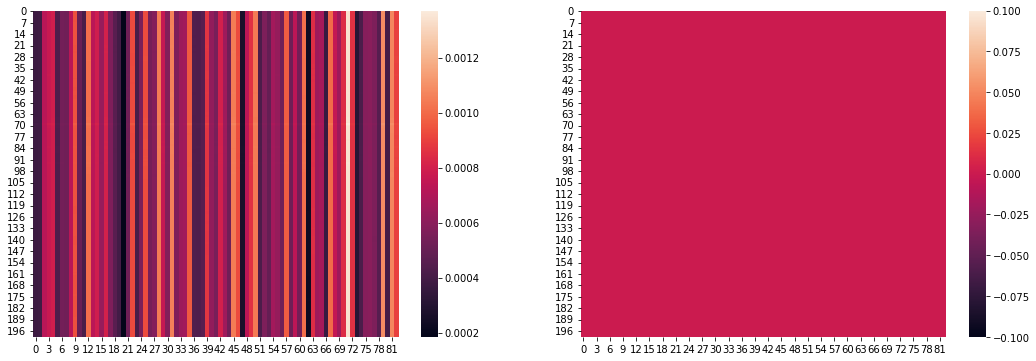

In [ ]:
musicnet_eval(lstm_2, test_generator, 3)

We still observe the same pattern, that constant values are passed along the timesteps.

The x-axis above represents the 81 notes, and y-axis represetns the timesteps.

The figure on the left represents the prediction of our model, whereas the right figure represents the true labels.

# Conv to lstm

Attempts last architecture of padding filters of convolutional layers to LSTM layers. This is the most basic model that extract features by convolutional layers, and passing the feature through the sequnce to make a prediction.

In [ ]:
BATCH_SIZE = 8

# We have choose to work with 128 frequency bins,
# and the None input shape indicates the dynamic length of time dimension
inp = Input((None, 128, 1), batch_size=BATCH_SIZE)
normalizer = layers.BatchNormalization()(inp)

# Extracting features from first convolutional layers.
# Padding set to same to maintain same time dimension
conv_1 = Conv2D(30, (50, 40), padding = 'same')(normalizer)

normalizer_2 = layers.BatchNormalization()(conv_1)
# pool_1 = layers.TimeDistributed(MaxPool1D(2))(normalizer_2)
# flatten_1 = flatten = layers.TimeDistributed(layers.Flatten())(pool_1)

# conv_2 = layers.Conv2D(5, (1000, 30), padding = 'same')(pool_1)
# pool_2 = layers.TimeDistributed(layers.MaxPool1D(2))(conv_2)

# Flatten each filter layer for each timesteps
flatten = layers.TimeDistributed(Flatten())(normalizer_2)

drop_1 = layers.Dropout(0.3)(flatten)
# # Feed in the flattened layers to multiple layers of Dense layer,
# # Performing embedding
# Dense_1 = layers.TimeDistributed(Dense(300, activation = 'relu'))(flatten)
# normalizer_3 = layers.BatchNormalization()(Dense_1)
# drop_1 = layers.Dropout(0.2)(normalizer_3)

# Dense_2 = layers.TimeDistributed(Dense(150, activation = 'relu'))(drop_1)
# normalizer_4 = layers.BatchNormalization()(Dense_2)
# drop_2 = layers.Dropout(0.2)(normalizer_4)

# Dense_3 = layers.TimeDistributed(Dense(50, activation = 'relu'))(drop_2)
# normalizer_5 = layers.BatchNormalization()(Dense_3)
# drop_3 = layers.Dropout(0.2)(normalizer_5)

# Dense_3 = layers.TimeDistributed(Dense(200, activation = 'relu'))(drop_2)
# normalizer_5 = layers.BatchNormalization()(Dense_3)
# drop_3 = layers.Dropout(0.2)(normalizer_5)

# Lastly, put the decoded features in to LSTM layer
last_lstm = LSTM(500, return_sequences=True, dropout = 0.3)(drop_1)

# Outputing to final Dense layer with sigmoid activation,
# To predict the note labels for each timesteps
conv_to_lstm_model = Model(inp, [instrument_layer_simple(last_lstm,
                                f"instrument_{ins}") for ins in instrument_list])


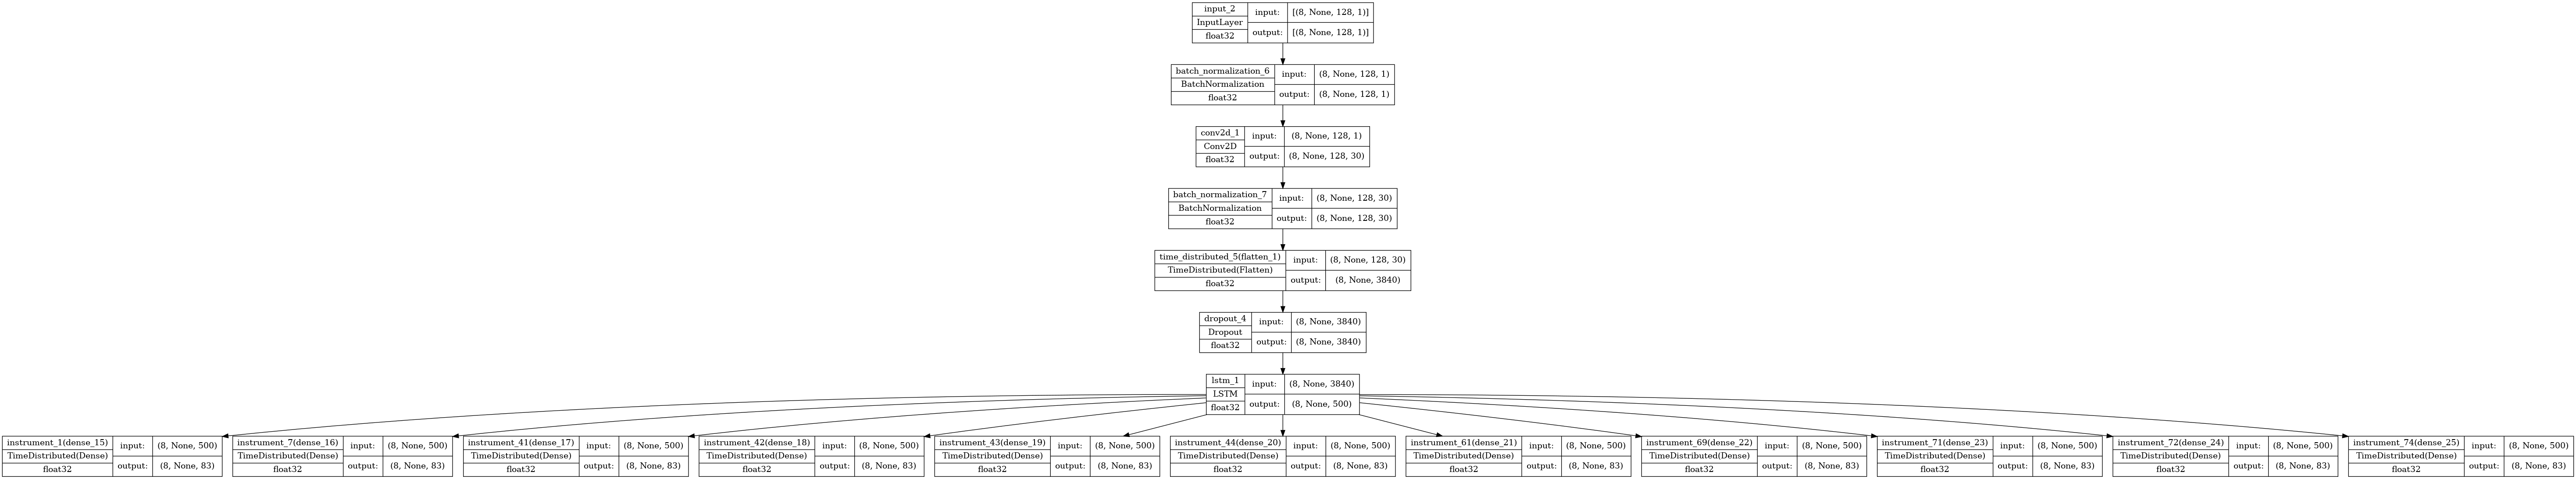

In [ ]:
tf.keras.utils.plot_model(conv_to_lstm_model, show_shapes=True, show_dtype=True)


In [ ]:
classic_train_generator =  classic_generator(mode='train', batch_size=BATCH_SIZE)
                        # (tf.dtypes.float32, tf.dtypes.bool))

classic_eval_generator = classic_generator(mode='test', batch_size=BATCH_SIZE, preprocess = False)

In [ ]:
def weighted_cross_entropy_with_logits(labels, logits):
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels, logits, pos_weight = 5
        )
    return loss

def my_loss():
    return weighted_cross_entropy_with_logits

# As mentioned before, since our prediction is a sparse multilabel problem, 
# the accuracy might not makes muc of sense, in addition, we will be adding
# AUC for each instrument to gauge how well the model is performing
conv_to_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                          loss={f"instrument_{ins}": my_loss() 
                                for ins in instrument_list},
                          metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/classic_direct_conv_to_lstm/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_classic_direct_conv_to_lstm",
    monitor='val_accuracy',
    save_freq='epoch')
    
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)


conv_to_lstm_history = conv_to_lstm_model.fit(classic_train_generator, 
                                                epochs=10,
                                                validation_data=classic_eval_generator,
                                                validation_freq=1,
                                                # use_multiprocessing= True,
                                                # workers= 3,
                                                verbose=1,
                                                # class_weight= {0: 0.11, 1: 0.89}, 
                                                callbacks=[ckpt_callback])

Epoch 1/10


2022-08-07 18:44:58.981777: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-07 18:44:59.811714: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 18:44:59.813228: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 18:44:59.813276: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-07 18:44:59.814714: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 18:44:59.814829: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


40/40 [==============================] - ETA: 0s - loss: 9.4632 - instrument_1_loss: 0.9001 - instrument_7_loss: 0.8716 - instrument_41_loss: 0.8497 - instrument_42_loss: 0.8685 - instrument_43_loss: 0.8520 - instrument_44_loss: 0.8687 - instrument_61_loss: 0.8508 - instrument_69_loss: 0.8303 - instrument_71_loss: 0.8733 - instrument_72_loss: 0.8566 - instrument_74_loss: 0.8417 - instrument_1_accuracy: 0.0041 - instrument_1_auc_1: 0.4734 - instrument_7_accuracy: 0.0077 - instrument_7_auc_1: 0.3513 - instrument_41_accuracy: 0.0077 - instrument_41_auc_1: 0.5359 - instrument_42_accuracy: 0.0058 - instrument_42_auc_1: 0.5681 - instrument_43_accuracy: 0.0010 - instrument_43_auc_1: 0.5255 - instrument_44_accuracy: 0.0014 - instrument_44_auc_1: 0.5647 - instrument_61_accuracy: 0.0016 - instrument_61_auc_1: 0.4531 - instrument_69_accuracy: 0.0015 - instrument_69_auc_1: 0.6652 - instrument_71_accuracy: 0.0340 - instrument_71_auc_1: 0.6068 - instrument_72_accuracy: 6.7188e-04 - instrument_72_auc

2022-08-07 19:00:44.902483: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-08-07 19:00:44.963806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-08-07 19:00:44.996746: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_01_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_01_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 977s 24s/step - loss: 9.4632 - instrument_1_loss: 0.9001 - instrument_7_loss: 0.8716 - instrument_41_loss: 0.8497 - instrument_42_loss: 0.8685 - instrument_43_loss: 0.8520 - instrument_44_loss: 0.8687 - instrument_61_loss: 0.8508 - instrument_69_loss: 0.8303 - instrument_71_loss: 0.8733 - instrument_72_loss: 0.8566 - instrument_74_loss: 0.8417 - instrument_1_accuracy: 0.0041 - instrument_1_auc_1: 0.4734 - instrument_7_accuracy: 0.0077 - instrument_7_auc_1: 0.3513 - instrument_41_accuracy: 0.0077 - instrument_41_auc_1: 0.5359 - instrument_42_accuracy: 0.0058 - instrument_42_auc_1: 0.5681 - instrument_43_accuracy: 0.0010 - instrument_43_auc_1: 0.5255 - instrument_44_accuracy: 0.0014 - instrument_44_auc_1: 0.5647 - instrument_61_accuracy: 0.0016 - instrument_61_auc_1: 0.4531 - instrument_69_accuracy: 0.0015 - instrument_69_auc_1: 0.6652 - instrument_71_accuracy: 0.0340 - instrument_71_auc_1: 0.6068 - instrument_72_accuracy: 6.7188e-04 - instrument_

2022-08-07 19:17:20.517681: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-08-07 19:17:20.554600: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_02_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_02_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 995s 25s/step - loss: 8.1047 - instrument_1_loss: 0.7867 - instrument_7_loss: 0.7376 - instrument_41_loss: 0.7359 - instrument_42_loss: 0.7357 - instrument_43_loss: 0.7339 - instrument_44_loss: 0.7341 - instrument_61_loss: 0.7287 - instrument_69_loss: 0.7197 - instrument_71_loss: 0.7377 - instrument_72_loss: 0.7307 - instrument_74_loss: 0.7239 - instrument_1_accuracy: 0.0014 - instrument_1_auc_1: 0.4879 - instrument_7_accuracy: 0.0012 - instrument_7_auc_1: 0.4978 - instrument_41_accuracy: 0.0033 - instrument_41_auc_1: 0.5315 - instrument_42_accuracy: 0.0027 - instrument_42_auc_1: 0.5510 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5280 - instrument_44_accuracy: 0.0014 - instrument_44_auc_1: 0.4818 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.3864 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.6101 - instrument_71_accuracy: 0.0000e+00 - instrument_71_auc_1: 0.5646 - instrument_72_accuracy: 0.0000e+

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_03_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_03_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 956s 24s/step - loss: 7.8624 - instrument_1_loss: 0.7675 - instrument_7_loss: 0.7092 - instrument_41_loss: 0.7183 - instrument_42_loss: 0.7135 - instrument_43_loss: 0.7129 - instrument_44_loss: 0.7078 - instrument_61_loss: 0.7065 - instrument_69_loss: 0.7039 - instrument_71_loss: 0.7093 - instrument_72_loss: 0.7083 - instrument_74_loss: 0.7054 - instrument_1_accuracy: 0.0159 - instrument_1_auc_1: 0.4918 - instrument_7_accuracy: 0.0010 - instrument_7_auc_1: 0.5659 - instrument_41_accuracy: 0.0036 - instrument_41_auc_1: 0.5233 - instrument_42_accuracy: 0.0012 - instrument_42_auc_1: 0.5637 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5550 - instrument_44_accuracy: 0.0020 - instrument_44_auc_1: 0.5860 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.3889 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.6318 - instrument_71_accuracy: 1.5625e-05 - instrument_71_auc_1: 0.5802 - instrument_72_accuracy: 0.0000e+

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_04_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_04_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 840s 21s/step - loss: 7.8032 - instrument_1_loss: 0.7629 - instrument_7_loss: 0.7022 - instrument_41_loss: 0.7141 - instrument_42_loss: 0.7073 - instrument_43_loss: 0.7084 - instrument_44_loss: 0.7014 - instrument_61_loss: 0.7015 - instrument_69_loss: 0.6996 - instrument_71_loss: 0.7028 - instrument_72_loss: 0.7026 - instrument_74_loss: 0.7005 - instrument_1_accuracy: 0.0195 - instrument_1_auc_1: 0.4969 - instrument_7_accuracy: 5.4688e-04 - instrument_7_auc_1: 0.5081 - instrument_41_accuracy: 0.0056 - instrument_41_auc_1: 0.5313 - instrument_42_accuracy: 0.0000e+00 - instrument_42_auc_1: 0.5713 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5383 - instrument_44_accuracy: 6.0938e-04 - instrument_44_auc_1: 0.5499 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.4050 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.5505 - instrument_71_accuracy: 4.6875e-05 - instrument_71_auc_1: 0.5238 - instrument_72_accura

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_05_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_05_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 809s 20s/step - loss: 7.7747 - instrument_1_loss: 0.7576 - instrument_7_loss: 0.6996 - instrument_41_loss: 0.7121 - instrument_42_loss: 0.7049 - instrument_43_loss: 0.7059 - instrument_44_loss: 0.6988 - instrument_61_loss: 0.6990 - instrument_69_loss: 0.6979 - instrument_71_loss: 0.7001 - instrument_72_loss: 0.7005 - instrument_74_loss: 0.6984 - instrument_1_accuracy: 0.0180 - instrument_1_auc_1: 0.4997 - instrument_7_accuracy: 9.6875e-04 - instrument_7_auc_1: 0.4890 - instrument_41_accuracy: 0.0024 - instrument_41_auc_1: 0.5324 - instrument_42_accuracy: 0.0000e+00 - instrument_42_auc_1: 0.5521 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5446 - instrument_44_accuracy: 6.8750e-04 - instrument_44_auc_1: 0.4677 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.3171 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.6400 - instrument_71_accuracy: 0.0011 - instrument_71_auc_1: 0.5348 - instrument_72_accuracy: 

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_06_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_06_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 823s 20s/step - loss: 7.7649 - instrument_1_loss: 0.7601 - instrument_7_loss: 0.6981 - instrument_41_loss: 0.7116 - instrument_42_loss: 0.7037 - instrument_43_loss: 0.7046 - instrument_44_loss: 0.6974 - instrument_61_loss: 0.6981 - instrument_69_loss: 0.6968 - instrument_71_loss: 0.6986 - instrument_72_loss: 0.6990 - instrument_74_loss: 0.6970 - instrument_1_accuracy: 0.0159 - instrument_1_auc_1: 0.4878 - instrument_7_accuracy: 7.5000e-04 - instrument_7_auc_1: 0.4831 - instrument_41_accuracy: 0.0036 - instrument_41_auc_1: 0.5172 - instrument_42_accuracy: 0.0000e+00 - instrument_42_auc_1: 0.5709 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5191 - instrument_44_accuracy: 2.3437e-04 - instrument_44_auc_1: 0.3375 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.3742 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.5869 - instrument_71_accuracy: 4.6875e-05 - instrument_71_auc_1: 0.5242 - instrument_72_accura

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_07_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_07_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 1015s 26s/step - loss: 7.7545 - instrument_1_loss: 0.7566 - instrument_7_loss: 0.6973 - instrument_41_loss: 0.7104 - instrument_42_loss: 0.7032 - instrument_43_loss: 0.7040 - instrument_44_loss: 0.6965 - instrument_61_loss: 0.6975 - instrument_69_loss: 0.6961 - instrument_71_loss: 0.6978 - instrument_72_loss: 0.6986 - instrument_74_loss: 0.6965 - instrument_1_accuracy: 0.0227 - instrument_1_auc_1: 0.5040 - instrument_7_accuracy: 9.5313e-04 - instrument_7_auc_1: 0.5582 - instrument_41_accuracy: 0.0034 - instrument_41_auc_1: 0.5480 - instrument_42_accuracy: 1.5625e-05 - instrument_42_auc_1: 0.5572 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5104 - instrument_44_accuracy: 6.0938e-04 - instrument_44_auc_1: 0.4126 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.4421 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.5621 - instrument_71_accuracy: 1.4062e-04 - instrument_71_auc_1: 0.5336 - instrument_72_accur

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_08_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_08_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 1063s 27s/step - loss: 7.7481 - instrument_1_loss: 0.7563 - instrument_7_loss: 0.6965 - instrument_41_loss: 0.7097 - instrument_42_loss: 0.7023 - instrument_43_loss: 0.7032 - instrument_44_loss: 0.6959 - instrument_61_loss: 0.6970 - instrument_69_loss: 0.6959 - instrument_71_loss: 0.6972 - instrument_72_loss: 0.6981 - instrument_74_loss: 0.6960 - instrument_1_accuracy: 0.0177 - instrument_1_auc_1: 0.5015 - instrument_7_accuracy: 6.2500e-04 - instrument_7_auc_1: 0.5371 - instrument_41_accuracy: 0.0034 - instrument_41_auc_1: 0.5368 - instrument_42_accuracy: 1.5625e-05 - instrument_42_auc_1: 0.5660 - instrument_43_accuracy: 0.0000e+00 - instrument_43_auc_1: 0.5082 - instrument_44_accuracy: 8.2812e-04 - instrument_44_auc_1: 0.4698 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.4768 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.5771 - instrument_71_accuracy: 1.8750e-04 - instrument_71_auc_1: 0.5660 - instrument_72_accur

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_09_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_09_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 1070s 27s/step - loss: 7.7462 - instrument_1_loss: 0.7569 - instrument_7_loss: 0.6962 - instrument_41_loss: 0.7102 - instrument_42_loss: 0.7022 - instrument_43_loss: 0.7034 - instrument_44_loss: 0.6954 - instrument_61_loss: 0.6962 - instrument_69_loss: 0.6956 - instrument_71_loss: 0.6970 - instrument_72_loss: 0.6976 - instrument_74_loss: 0.6956 - instrument_1_accuracy: 0.0090 - instrument_1_auc_1: 0.4916 - instrument_7_accuracy: 8.7500e-04 - instrument_7_auc_1: 0.4746 - instrument_41_accuracy: 0.0042 - instrument_41_auc_1: 0.5434 - instrument_42_accuracy: 1.5625e-05 - instrument_42_auc_1: 0.5592 - instrument_43_accuracy: 1.5625e-05 - instrument_43_auc_1: 0.5093 - instrument_44_accuracy: 0.0019 - instrument_44_auc_1: 0.5424 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.4239 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.5228 - instrument_71_accuracy: 6.8750e-04 - instrument_71_auc_1: 0.5023 - instrument_72_accuracy:

INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_10_classic_direct_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/classic_direct_conv_to_lstm/20220807_184403_10_classic_direct_conv_to_lstm/assets


40/40 [==============================] - 1063s 27s/step - loss: 7.7444 - instrument_1_loss: 0.7565 - instrument_7_loss: 0.6958 - instrument_41_loss: 0.7102 - instrument_42_loss: 0.7021 - instrument_43_loss: 0.7035 - instrument_44_loss: 0.6952 - instrument_61_loss: 0.6963 - instrument_69_loss: 0.6953 - instrument_71_loss: 0.6967 - instrument_72_loss: 0.6973 - instrument_74_loss: 0.6954 - instrument_1_accuracy: 0.0147 - instrument_1_auc_1: 0.4936 - instrument_7_accuracy: 8.5937e-04 - instrument_7_auc_1: 0.5001 - instrument_41_accuracy: 0.0035 - instrument_41_auc_1: 0.5259 - instrument_42_accuracy: 1.5625e-05 - instrument_42_auc_1: 0.5330 - instrument_43_accuracy: 3.1250e-05 - instrument_43_auc_1: 0.4885 - instrument_44_accuracy: 0.0027 - instrument_44_auc_1: 0.5748 - instrument_61_accuracy: 0.0000e+00 - instrument_61_auc_1: 0.4723 - instrument_69_accuracy: 0.0000e+00 - instrument_69_auc_1: 0.5207 - instrument_71_accuracy: 0.0010 - instrument_71_auc_1: 0.4945 - instrument_72_accuracy: 0.0

In [ ]:
conv_to_lstm_model.save('../models/new_classic_conv_to_lstm/')

INFO:tensorflow:Assets written to: ../models/new_classic_conv_to_lstm/assets


INFO:tensorflow:Assets written to: ../models/new_classic_conv_to_lstm/assets


In [ ]:
save_history(conv_to_lstm_history.history, '../models/new_classic_conv_to_lstm.pkl')

1/1 [==============================] - 0s 25ms/step


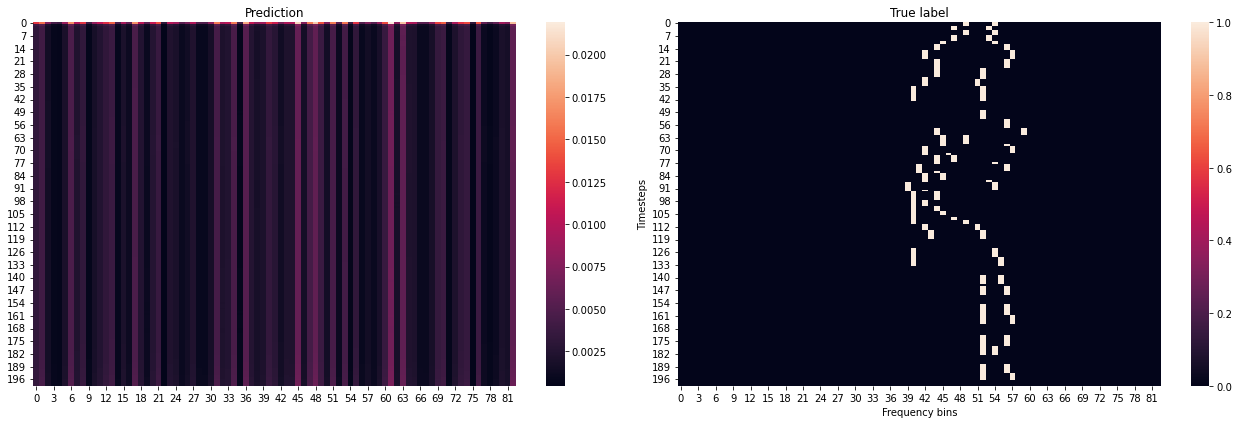

In [ ]:
musicnet_eval(conv_to_lstm_model, classic_eval_generator, 2)

Again, same behavior is observed, we have concluded that the input data might be incompatible for our model, further investigation on the input pipeline should be taken.